<a href="https://colab.research.google.com/github/krisograbek/cover-type/blob/main/CoverType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The purpose of this notebook is to explain challenges for Multi-class Classification with Imbalanced Data. 

We cover:
 - the techniques of dealing with imbalanced data
 - how to apply cost-sensitive learning using scikit-learn
 - the average types and their meaning for the f1 metric



## About Dataset

Will be using CoverType dataset, which is great for this kind of problem. Data Set source (fetched via sklearn): https://archive.ics.uci.edu/ml/datasets/covertype

The Forest Cover Type Dataset consists of forest observations for 30 x 30 meter cells. Independent variables were derived from data
originally obtained from US Geological Survey (USGS) and USFS data. This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.  These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

### Attribute Information

12 measures expanded to 54 columns: Wilderness Area and Soil Type are already one-hot-encoded. Total number of observations equals 581012.

| Name | Data Type | Measurement | Description |
|----------|-------------|------|------:|
Elevation                             |  quantitative  | meters                      | Elevation in meters
Aspect                                |  quantitative  | azimuth                     | Aspect in degrees azimuth
Slope                                 |  quantitative  | degrees                     | Slope in degrees
Horizontal_Distance_To_Hydrology      |  quantitative  | meters                      | Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology        |  quantitative  | meters                      | Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways       |  quantitative  | meters                      | Horz Dist to nearest roadway
Hillshade_9am                         |  quantitative  | 0 to 255 index              | Hillshade index at 9am, summer solstice
Hillshade_Noon                        |  quantitative  | 0 to 255 index              | Hillshade index at noon, summer soltice
Hillshade_3pm                         |  quantitative  | 0 to 255 index              | Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points    |  quantitative  | meters                      | Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns)    |  qualitative   | 0 (absence) or 1 (presence) | Wilderness area designation
Soil_Type (40 binary columns)         |  qualitative   | 0 (absence) or 1 (presence) | Soil Type designation


Based on attributes we predict the cover type for each observation.

### Forest Cover Type Classes:

0. Spruce/Fir
1. Lodgepole Pine
2. Ponderosa Pine
3. Cottonwood/Willow
4. Aspen
5. Douglas-fir
6. Krummholz

You can find more information here: https://archive.ics.uci.edu/ml/datasets/covertype

The Data is great for learning and experimenting purposes for many reasons:
 - it has many instances (over 500k)
 - it is numerical and clean (no missing values)
 - it is multiclass (7 classes)
 - it is highly imbalanced (2 most common classes ~85% in total, least represented class ~0,5%)
 - it can be downloaded with a single line of code: `sklearn.dataset.fetch_covtype()`

 


## Class Imbalance in Multiclass Classification

Imbalanced classifications are the predictions where the distribution of instances across classes is not equal. This creates a challenge in Machine Learning. Many traditional algorithms are less effective when dealing with disproportion in class representation. The biggest problem is predicting the least represented classes. Choosing the proper metric to evaluate models can also be confusing.

Possible ways of dealing with the challenges:
 - Applying cost-sensitive learning
 - Choosing more appropriate algorythms
 - Artificial oversampling of the least represented instances. This should be performed only on the train set.

In [1]:
# upgrade matplotlib
!pip install --upgrade matplotlib>=3.4.2
import matplotlib
matplotlib.__version__

'3.4.3'

# Code

## Imports

In [2]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score,
    log_loss,
    roc_auc_score,
    make_scorer
)

import warnings
warnings.filterwarnings('ignore')

## Data Import

In [3]:
covtype = fetch_covtype()
data, target = covtype["data"], covtype["target"]

## Preprocessing

There are 12 measures expanded to 54 columns. The first 10 columns are numerical. Following 4 are one-hot-encoded Wilderness areas and the last 40 are one-hot-encoded soil types. The whole preprocessing consists splitting the data and scaling the numerical columns.

In [4]:
# target classes
list(np.unique(target))

[1, 2, 3, 4, 5, 6, 7]

Classes have labels in range of 1 to 7. Let's just change it to 0-6.

In [5]:
# change target range to 0-6
target = target - min(target)
# show target distribution
print("Target distribution: ", np.bincount(target) / len(target))

Target distribution:  [0.36460521 0.48759922 0.06153746 0.00472796 0.01633873 0.02989095
 0.03530048]


### Plotting the Class Distribution

We already know the data is imabalanced. Let's plot the target distribution to picture that.

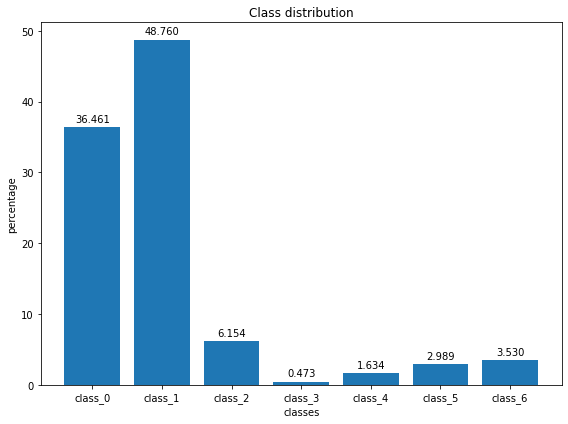

In [6]:
def plot_bar_chart(yvalues, xlabel="classes", ylabel="ylabel", title="title", figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    x = list(range(len(yvalues)))
    xlabels = ["class_" + str(c) for c in x]
    rect = ax.bar(x, yvalues);

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


    ax.bar_label(rect, padding=3, fmt='%.3f')

    fig.tight_layout();

target_dist = np.bincount(target) / len(target) * 100
x = list(np.unique(target))

plot_bar_chart(target_dist, ylabel="percentage", title="Class distribution")

The first two classes dominate the distribution. Over 85% of our examples belong to one of them. On the other hand, classes 3, 4, 5, and 6 have poor representation. Only one of over 200 examples labels class 3.

### Splitting the data

In [7]:
# Helping functions
def print_shapes(X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train shapes - data: {}, target: {}".format(X_train.shape, y_train.shape))
    print("Val shapes - data: {}, target: {}".format(X_val.shape, y_val.shape))
    print("Test shapes - data: {}, target: {}".format(X_test.shape, y_test.shape))

def print_class_distribution(y_train, y_val, y_test):
    print("Classes distribution")
    print("Train set: ", np.bincount(y_train) / len(y_train))
    print("Val set: ", np.bincount(y_val) / len(y_val))
    print("Test set: ", np.bincount(y_test) / len(y_test))

We'll use 100k examples and split them in the 70/15/15 ratio. Since data is highly imbalanced, it is important to keep the same target distribution for train, validation, and test sets. We achieve it by adding `stratify=target` parameter to the `train_test_split()` function.

In [8]:
random_state = 21

sample_size = 100000
test_size, val_size = 15000, 15000

_, X_train, _, y_train = train_test_split(data, target, stratify=target, test_size=sample_size, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=test_size, random_state=random_state)

print_shapes(X_train, y_train, X_val, y_val, X_test, y_test)
print_class_distribution(y_train, y_val, y_test)


Train shapes - data: (70000, 54), target: (70000,)
Val shapes - data: (15000, 54), target: (15000,)
Test shapes - data: (15000, 54), target: (15000,)
Classes distribution
Train set:  [0.3646     0.4876     0.06154286 0.00472857 0.01634286 0.0299
 0.03528571]
Val set:  [0.3646     0.4876     0.06153333 0.00473333 0.01633333 0.02986667
 0.03533333]
Test set:  [0.3646     0.4876     0.06153333 0.00473333 0.01633333 0.02986667
 0.03533333]


In [9]:
def plot_grouped_bar(metrics1, metrics2, label1, label2, xlabel="xlabel", ylabel="ylabel", title="title", figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(metrics1))
    xlabels = ["class_" + str(c) for c in x]

    width = 0.4
    
    rects1 = ax.bar(x - width/2, metrics1, width, label=label1)
    rects2 = ax.bar(x + width/2, metrics2, width, label=label2)

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc="best")

    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')

    fig.tight_layout();


### Scaling

We scale only numerical colums. Hence the first ten of them.

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[:, :10])
X_train_scaled = np.concatenate([X_train_scaled, X_train[:, 10:]], axis=1)

X_val_scaled = scaler.transform(X_val[:, :10])
X_val_scaled = np.concatenate([X_val_scaled, X_val[:, 10:]], axis=1)

X_test_scaled = scaler.transform(X_test[:, :10])
X_test_scaled = np.concatenate([X_test_scaled, X_test[:, 10:]], axis=1)

In [11]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((70000, 54), (15000, 54), (15000, 54))

## Training a Model

Let's use Logistic Regression with default parameters as our baseline model. We add `random_state` in order to reproduce results.

Note: We chose Logistic Regression as a baseline model, knowing algorithms based on Decision Trees give much better results. However, they are less prone to show improvement after applying cost-sensitive learning. 

In [12]:
logreg = LogisticRegression(random_state=random_state)

logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
def get_per_class_metrics(ytest, ypred):
    precision_arr = precision_score(ytest, ypred, average=None)
    recall_arr = recall_score(ytest, ypred, average=None)
    f1_arr = f1_score(ytest, ypred, average=None)

    return precision_arr, recall_arr, f1_arr

def get_overall_metrics(ytest, ypred, average="weighted"):
    acc = accuracy_score(ytest, ypred)

    precision = precision_score(ytest, ypred, average=average)
    recall = recall_score(ytest, ypred, average=average)
    f1 = f1_score(ytest, ypred, average=average)

    return acc, precision, recall, f1

def print_scores(acc, precision, recall, f1):
    print("Accuracy: ", acc)
    print("precision score:", precision)
    print("recall score:", recall)
    print("F1 score:", f1)

In [14]:
def train_and_evaluate(est, X_train, y_train, X_val, y_val, est_type, average):

    est.fit(X_train, y_train)
    predictions = {
        k: est.predict(v) for k, v in zip(["train", "val"], [X_train, X_val])
    }

    avg_types = ["weighted", "macro"]

    metrics_map = {}
    for split, label in zip(["train", "val"], [y_train, y_val]):
        metrics_avg = {}
        for avg in avg_types:
            acc, precision, recall, f1 = get_overall_metrics(
                label, predictions[split], avg
            )
            metrics_avg[avg] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
            }

        per_class_precision, per_class_recall, per_class_f1 = get_per_class_metrics(
            label, predictions[split]
        )

        cm = confusion_matrix(label, predictions[split])

        metrics_map[split] = {
            "acc": acc,
            "precision": per_class_precision,
            "recall": per_class_recall,
            "f1": per_class_f1,
            "metrics_avg": metrics_avg,
            "cm": cm
        }

    return metrics_map

### Predictions

In [15]:
pred_train = logreg.predict(X_train_scaled)
pred_val = logreg.predict(X_val_scaled)

## Evaluating the Trained model

### Accuracy

In [16]:
acc_train = accuracy_score(y_train, pred_train)
acc_val = accuracy_score(y_val, pred_val)
print("Accuracies - train: {:.4f}, val {:.4f}".format(acc_train, acc_val))

Accuracies - train: 0.7235, val 0.7211



We got over 72% accuracy on both train and validation sets. This isn't bad, since we trained a default model.




### f1 score

An f1 score is the preferred metric to evaluate models for imbalanced data. In multi-class tasks, we get an f1 score, precision, and recall for each class. If we want a single value for model evaluation, we set the average parameter to weighted, micro, or macro. Let's begin with the first one.

F1 score is the preffered metric to evaluate models for imbalanced data. In multiclass tasks, we get an f1 score (along with precision and recall) for each individual class. Hence, we got 7 scores. To get a single value for model evaluation, we set the `average` parameter to "weighted", "micro", or "macro". Let's begin with the first one.

In [17]:
f1_train = f1_score(y_train, pred_train, average="weighted")
f1_val = f1_score(y_val, pred_val, average="weighted")
print("f1 scores - train: {:.4f}, val {:.4f}".format(f1_train, f1_val))

f1 scores - train: 0.7133, val 0.7113


Slightly worse than accuracy. Over 71% on both train and validation sets. How about "micro"?

In [18]:
f1_train = f1_score(y_train, pred_train, average="micro")
f1_val = f1_score(y_val, pred_val, average="micro")
print("f1 scores - train: {:.4f}, val {:.4f}".format(f1_train, f1_val))

f1 scores - train: 0.7235, val 0.7211


Have you seen the numbers already? Have a look at the accuracies. Yep, there is no coinsidence. This is pretty much what the micro average does. It produces precision, recall, and f1 score equal to accuracy. We won't dig any deeper into micro average in this article.

For further reading check out the sklearn documentation: [multiclass-and-multilabel-classification](https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification)

In [19]:
precision_train = precision_score(y_train, pred_train, average="micro")
precision_val = precision_score(y_val, pred_val, average="micro")
recall_train = recall_score(y_train, pred_train, average="micro")
recall_val = recall_score(y_val, pred_val, average="micro")


In [20]:
precision_train, recall_train

(0.7235142857142857, 0.7235142857142857)

In [21]:
precision_val, recall_val

(0.7211333333333333, 0.7211333333333333)

Let's check the macro average

In [22]:
f1_train = f1_score(y_train, pred_train, average="macro")
f1_val = f1_score(y_val, pred_val, average="macro")
print("f1 scores - train: {:.4f}, val {:.4f}".format(f1_train, f1_val))

f1 scores - train: 0.5232, val 0.5275


That's a drop! 52%?! What's the difference between weighted and macro f1 score? As mentioned, each class has its own f1 score. Averaged scores return a single value and don't tell us much about each individual one. 

Let's visualize f1 score for each class.

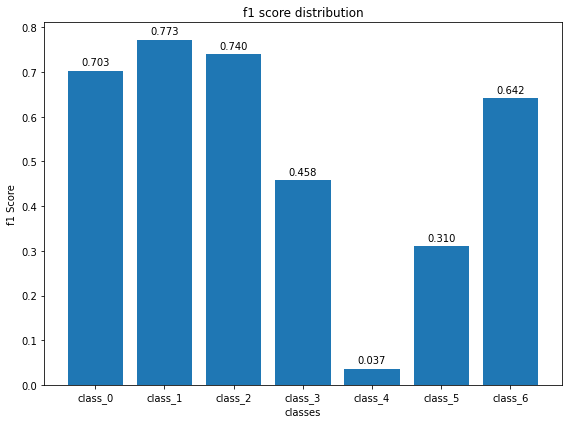

In [23]:
f1_arr_train = f1_score(y_train, pred_train, average=None)
plot_bar_chart(f1_arr_train, ylabel="f1 Score", title="f1 score distribution")

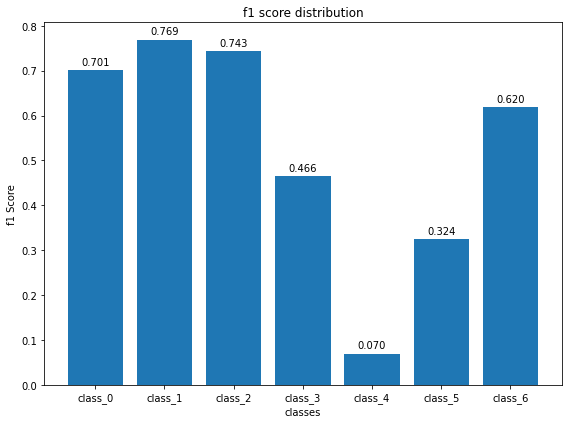

In [24]:
f1_arr_val = f1_score(y_val, pred_val, average=None)
plot_bar_chart(f1_arr_val, ylabel="f1 Score", title="f1 score distribution")

This chart provides useful information:
 - there are disparities between scores
 - there are classes with low scores
 - f1 score for class 4 is extremely low - 3.7%
 - f1 scores for majority classes is over 70%

Individual scores the input for computing both weighted and macro average. Where does the contrast between the results come from?

Weighted f1 is a dot product of class distribution and f1 scores for each class. **The more samples of a class, the more impact it has on the score.**

Macro f1 score is the arithmetic average of f1 scores for each class. **Each class is equally important.**

Let's visualize that.

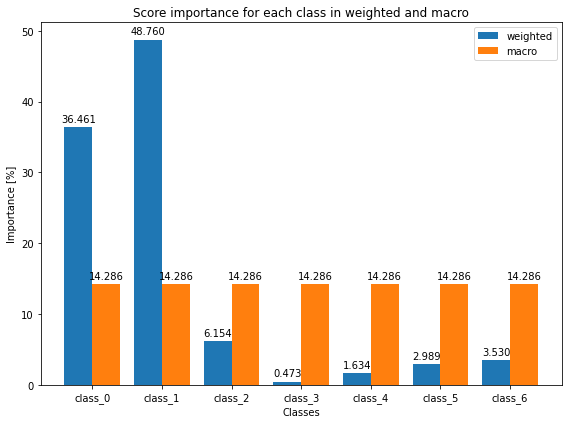

In [25]:
class_weights_macro = [100/7 for _ in range(7)]
plot_grouped_bar(
    target_dist, 
    class_weights_macro, 
    "weighted", 
    "macro",
    xlabel="Classes",
    ylabel="Importance [%]", 
    title="Score importance for each class in weighted and macro"
)


For weighted f1 score, low results for classes 3, 4, and 5 get almost entirely wiped off because of their insignificance in class distribution. This is where the gap between macro and weighted average come from. 

Total impact of classes 3, 4, and 5 for:
 - weighted f1 score: 0.47 + 1.63 + 2.99 ~ **5.1%**
 - macro f1 score: 3 x 14.28 ~ **42.8%**

In [26]:
def plot_grouped_3bars(metrics, labels, xlabel="xlabel", ylabel="ylabel", title="title", figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.tick_params(axis='both', which='major', labelsize=12)
    
    x = np.arange(len(metrics[0]))
    xlabels = ["class " + str(c) for c in x]

    width = 0.85 / len(metrics)

    rect1 = ax.bar(x - width, metrics[0], width, label=labels[0])
    rect2 = ax.bar(x, metrics[1], width, label=labels[1])
    rect3 = ax.bar(x + width, metrics[2], width, label=labels[2])
    
    ax.bar_label(rect1, padding=3, fmt='%.3f')
    ax.bar_label(rect2, padding=3, fmt='%.3f')
    ax.bar_label(rect3, padding=3, fmt='%.3f')
    
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="best")


    fig.tight_layout();

### Choosing the Right Metric

Which metric should you choose to evaluate your model? It depends on your goals:
 - if you want to have as many good predictions as possible, use a micro or weighted f1 score,
 - if you want to train a classifier for minority classes, use macro f1 score
 
In this project, our goal is to train a better classifier for classes with fewer instances. I.e. we want to increase the f1 score for classes 3, 4, and 5 while keeping the others relatively high.

Why is f1 score so small for these classes? It is computed based on precision and recall. Let's visualize them for more insights.

In [27]:
precision_arr_train = precision_score(y_train, pred_train, average=None)
recall_arr_train = recall_score(y_train, pred_train, average=None)
precision_arr_val = precision_score(y_val, pred_val, average=None)
recall_arr_val = recall_score(y_val, pred_val, average=None)

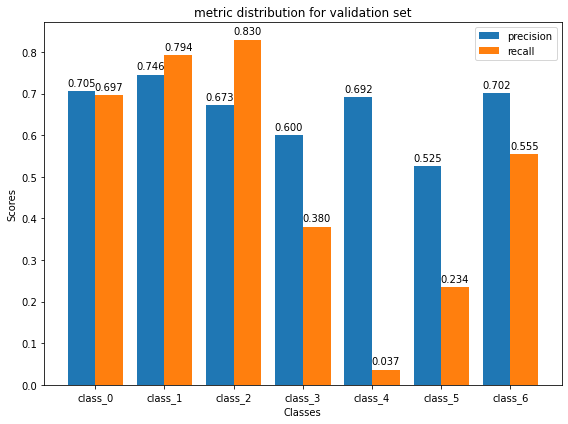

In [28]:
plot_grouped_bar(
    precision_arr_val, recall_arr_val,
    "precision", "recall",
    xlabel="Classes",
    ylabel="Scores", 
    title="metric distribution for validation set"
)

What can we get from this chart? These three things seem to be the most important:
 - only classes 1 and 2 have higher precision than recall. These are the classes with the highest f1
 - for classes 3, 4, and 5, recall is more than 20% lower than precision. These are the classes with the lowest f1
 - class 4 has an extremely low recall

How do precision and recall affect f1?
 - when both are high, f1 is also high,
 - when both are low, f1 is low,
 - f1 lies between the both values. However...
 - when one of them is much lower, it pulls f1 score down. Look at class 4 and 5. F1 score is much closer to the low recall.

The perfect situation is when both precision and recall are high. Unfortunately, it is often impossible. In this case, for the optimal f1 score we should aim to keep both metrics close to each other. Please, keep that in mind.

## Closer Look at the Metrics

Note: This part is optional. We compute recall for class 4 manually. If you're not interested scroll to "Cost-sensitive Learning".

I assume you've seen the equations:

Precision = TP / (TP + FP)

Recall =  TP / (TP + FN)

Let's stay with recall since it's clearly our main concern if we want to increase f1 score for classes with few instances. Recall is also called **sensitivity** or **True Positive Rate (TPR)**. But these equations apply for a binary classification problems. What are TP and FN in multiclass classification?

Well, they're different for each class. We got seven scores for each metric, because we have seven classes. This means, the score for each class is computed separately. 




### Manual Recall Computation (Not included in the article)

Let's compute recall manually for the 4th class

We begin with Actual Positives. These are the instances, that have the label = 4 in the train set.

In [29]:
# actual instances with label = 4
y_train_4 = y_train == 4
# total number of such instances
y_train_4_count = sum(i == True for i in y_train_4)
print(f"In the train set there are {y_train_4_count} instances of class 4")

In the train set there are 1144 instances of class 4


Let's compute Predicted Positives. These are the instances, that our model labeled as 4. 

In [30]:
# predicted instances for class 4
y_pred_4 = pred_train == 4
# total number of instances predicted as class 4
y_pred_4_count = sum(i == True for i in y_pred_4)
print(f"Predicted {y_pred_4_count} instances as class 4")

Predicted 60 instances as class 4


Only 60 compared to 1144. There are 70k instances in the train set. Our model "decided" to predict class 4 only 60 times. Even if all of them were correct, the recall must be low. How many are correct? 

We need to count instances that were True for both actual and predicted classes

In [31]:
# count correct predictions for 4th class
correct_4_count = sum(actual == predicted == True for actual, predicted in zip(y_train_4, y_pred_4))
print(f"Correctly predicted {correct_4_count} out of {y_train_4_count} instances of class 4")

Correctly predicted 22 out of 1144 instances of class 4


22 out of 1144. 

TPR_Class4 = # Correct Predictions of Class 4 / # Actual Instances of Class 4

And this is how we get the Recall for class 4

In [32]:
# manually computed recall for class 4
recall_4 = correct_4_count / y_train_4_count
recall_4

0.019230769230769232

We can compare it with the results from `recall_score`.

In [33]:
recall_4 == recall_arr_train[4]

True

What is the prediction of our model if not 4? We can plot a confusion matrix to find out

In [34]:
# font_scale = 1.2

def plot_cm(cm):
    plt.figure(figsize = (10,7))
    # sn.set(font_scale=font_scale) # for label size
    ticks = [f"class_{i}" for i in range(len(cm[0]))]
    sn.heatmap(
        cm, 
        annot=True, 
        fmt="d",
        robust=True,
        annot_kws={"size": 14},
        xticklabels=ticks,
        yticklabels=ticks,
        linewidths=0.5) # font size
    plt.xlabel("predicted classes")
    plt.ylabel("actual classes")
    plt.show();

def plot_binary_cm(cm, indices = [1, 4]):
    plt.figure(figsize = (6, 5))
    # sn.set(font_scale=font_scale) # for label size
    ticks = [f"class_{i}" for i in indices]
    sn.heatmap(
        cm, 
        annot=True, 
        fmt="d",
        robust=True,
        cbar=False,
        annot_kws={"size": 14},
        xticklabels=ticks,
        yticklabels=ticks,
        linewidths=0.5) # font size
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show();

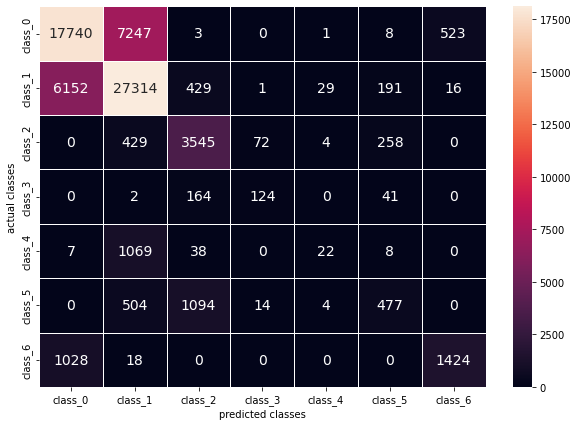

In [35]:
cm_train = confusion_matrix(y_train, pred_train)
plot_cm(cm_train)

The confusion matrix provides valuable information. What does it tell us about class 4? We have to look at the row and the column for class 4.  What can we see:
 - 22 [(actual) class4, (predicted) class4] - correct predictions
 - 1069! [class4, class1]. This is huge. 
 - 38 [class4, class2]
 - 29 [class1, class4]

1069?! Here, the recall score for class 4 gets destroyed. There are 1144 instances of class 4. Our model decided 1069 times to predict them as class 1. Why is our model doing this?

I'll be brutal. Our model doesn't care about class 4 if we use weighted f1 score. Why? Because bad recall, hence bad f1 score for the class 4 doesn't have much impact on the average score. There are about 30 times more instances of class 1 in our train set.

Let's take a closer look at classes 1 and 4

1069 is the number of instances predicted as class 1 that are actually class 4. They are false predictions. They are False Negatives if we consider a Binary Classifier for Class 4. They are False Positives if we consider a Classifier for Class 1. The higher the number the worse recall score for class 4 and the worse precision score for class 1. 

```
Class1 FP = Class4 FN = 1069
Class1 FN = Class4 FP = 29
Class1 TP = Class4 TN = 27314
Class1 TN = Class1 TP = 22
```

Metrics Class 1
Prec1 = TP / (TP + FP) = 27314 / (27314 + 1069)
Recall1 = TP / (TP + FN) = 27314 / (27314 + 29)

Metrics Class 4
Prec4 = TP / (TP + FP) = 22 / (22 + 29)
Recall4 = TP / (TP + FN) = 22 / (22 + 1069)


We can try to decrease the number. How can we do this? Let's introduce cost-sensitive training

## Cost-sensitive Learning

Cost-sensitive Learning is a subfield of Machine Learning that manipulates costs of misclassifications. Usually, we treat every error equally. Cost-sensitive learning applies different penalties for wrong predictions of each class. Since we try to minimize the overall loss (cost) our model will "pay attention" to classes with higher cost.

Further reading: [Cost-Sensitive Learning for Imbalanced Classification](https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/)

Cost-sensitive learning with scikit-learn is straightforward. We use `class_weight` parameter, which is an object where we define the cost of errors. By default `class_weight=None`, which means that value 1 is assigned to each class. 

In [36]:
def display_results(metrics_map, val=True, step="default model"):
    set_type = "val" if val else "train"
    print(f"f1 score macro: {metrics_map[set_type]['metrics_avg']['macro']['f1']}")
    print(f"Accuracy score: {metrics_map[set_type]['acc']}")
    precisions = metrics_map[set_type]['precision']
    recalls = metrics_map[set_type]['recall']
    f1_scores = metrics_map[set_type]['f1'] 
    
    plot_grouped_3bars(
        [precisions, recalls, f1_scores],
        ["precision", "recall", "f1"],
        xlabel="Classes",
        ylabel="Scores", 
        title=f"metric distribution {step}"
    )
    # plot_grouped_bar(
    #     precisions,
    #     recalls, 
    #     "precision", 
    #     "recall",
    #     xlabel="Classes",
    #     ylabel="Scores", 
    #     title="metric distribution"
    # )
    # plot_bar_chart(
    #     f1_scores,
    #     ylabel="f1 Score", 
    #     title="f1 score distribution"
    # )

def train_and_display(class_weights=None, val=True, step="default model"):
    logreg = LogisticRegression(class_weight=class_weights)

    average = "macro"
    metrics_map = train_and_evaluate(
        logreg,
        X_train_scaled,
        y_train,
        X_val_scaled,
        y_val,
        "logreg-weigted",
        average,
    )
    display_results(metrics_map, val=val, step=step)
    return metrics_map


## Tuning Hyperparameters

Let's tune class-weight hyperparameter. We'll begin with the default `LogisticRegression`

f1 score macro: 0.5274956569480519
Accuracy score: 0.7211333333333333


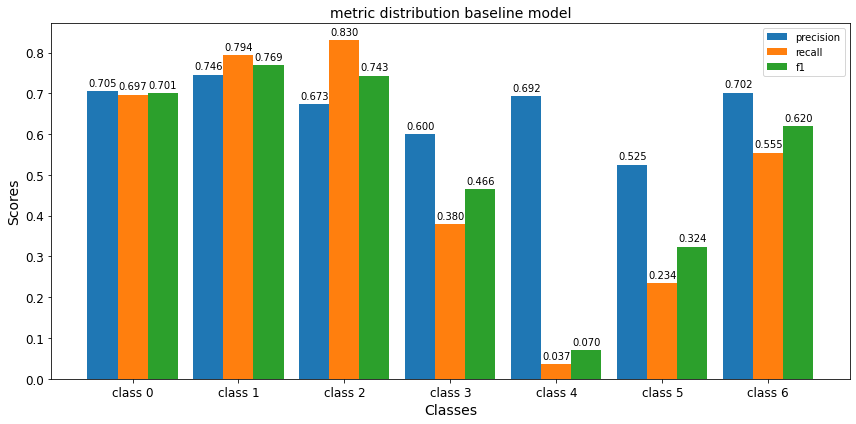

In [37]:
# all classes = 1, which is relevant to class_weight=None
class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}
metrics_base = train_and_display(class_weights=class_weights, step="baseline model")

Our baseline model has 72.1% accuracy and a 52.7% macro f1 score.

What's the goal of this tuning? Increase the macro f1 score.

How do we want to achieve this? By increasing f1 scores for classes with a low one.

How do we want to increase the score for these classes? By improving the recall for these classes. Also, we'll try to keep precisions and recalls close to each other. We'll penalize the model when it makes a false prediction for the instances. We'll use the `class_weight` parameter to increase the importance of classes with fewer examples.

Important: F1 score is high when both precision and recall are high. However, it is a luxury to be able to increase both of them. Usually, when we increase former, the latter decreases and vice versa. This is called precision-recall tradeoff. What we can do however, is to try to keep both metrics close to each other. This way f1 score will be relatively high.

Important note 2: This will look like every adjustment I made improved the metric. However, this is far from true. I experimented with many values and showed the best ones.

Let's begin with class 4. 

f1 score macro: 0.5579508114150992
Accuracy score: 0.7158


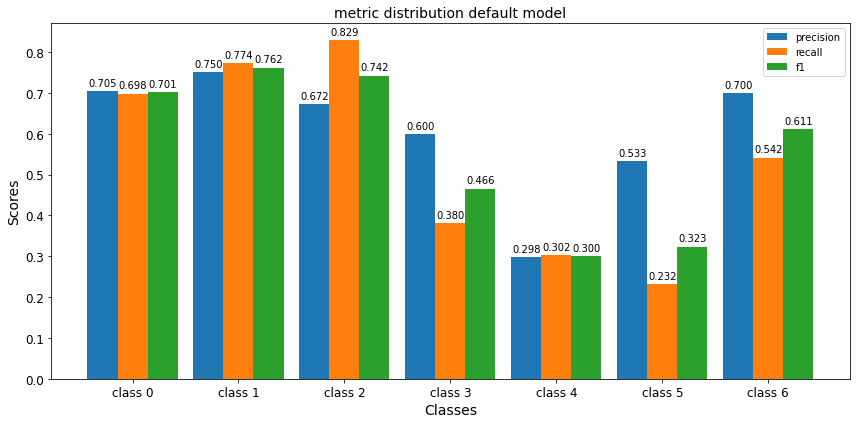

In [38]:
class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 4, 5: 1, 6: 1}
metrics_step1 = train_and_display(class_weights)

We changed only one weight and our macro f1 score increased by 3%. 
Do you see the improvement for the 4th class? By changing its weight we increased its f1 score from 7% to 30%! The recall is now over 30% compared to 3.7%. Precision and recall are almost identical, so we optimized the f1 score.
There are other classes with precision much higher than recall. Can we improve the f1 score? Let's change the following weights:
 - classes 3 and 5 -> 2 
 - class 6 -> 1.5.

f1 score macro: 0.5932156194123576
Accuracy score: 0.7136


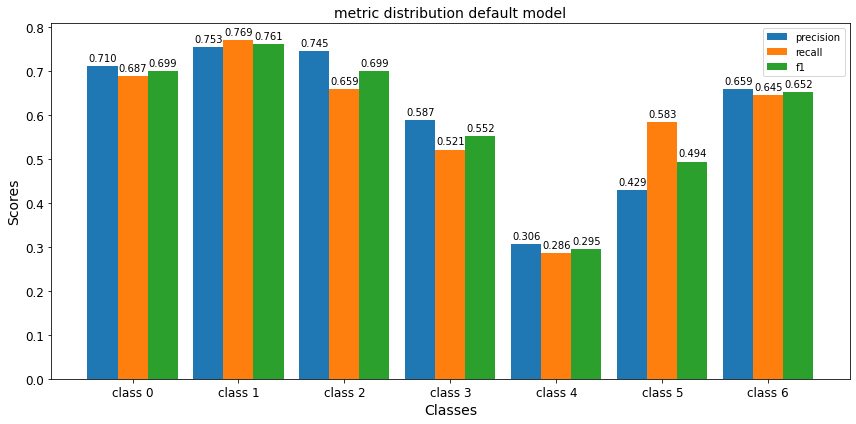

In [39]:
class_weights = {0: 1, 1: 1, 2: 1, 3: 2, 4: 4, 5: 2, 6: 1.5}
metrics_step2 =train_and_display(class_weights)

We reached the macro f1 score of 59.2%!

Let's have a look at precision-recall distribution. Five classes have both scores close to each other. Class 2 has much smaller recall than precision, class 5 the other way around. Can we fix this by slightly increasing the weight of class 2? Let's try 1.1.

f1 score macro: 0.593180459346944
Accuracy score: 0.7140666666666666


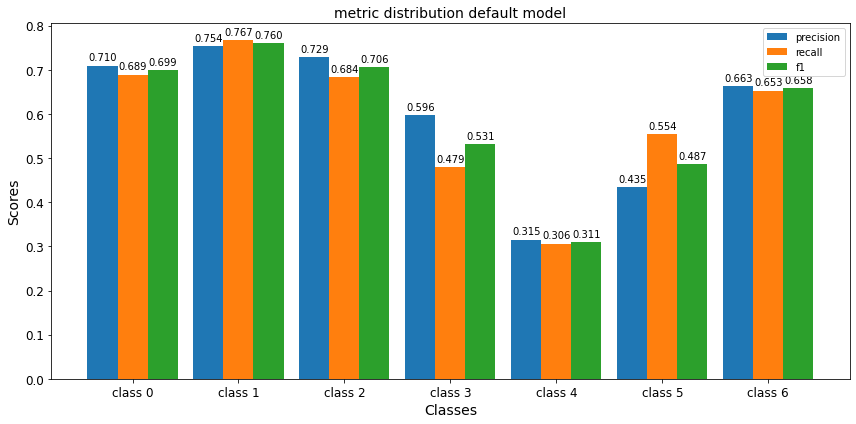

In [40]:
class_weights = {0: 1, 1: 1, 2: 1.1, 3: 2, 4: 4, 5: 2, 6: 1.5}
metrics_step3 = train_and_display(class_weights)

Another tiny improvement to 59.3%. We still should be able to improve scores for classes 3 and 5. Their precisions and recalls are far from each other. We don't want to tweak both weights at the same time. Let's increase the weight of class 3 to 2.4.

f1 score macro: 0.5951518641064365
Accuracy score: 0.7142666666666667


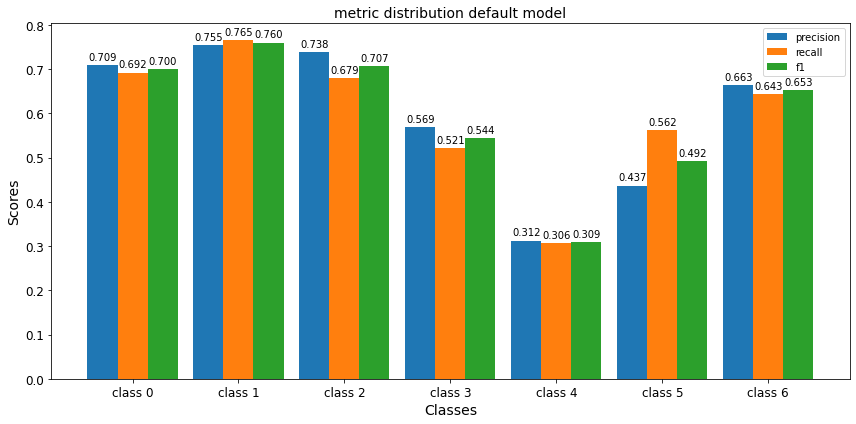

In [41]:
class_weights = {0: 1, 1: 1, 2: 1.1, 3: 2.4, 4: 4, 5: 2.0, 6: 1.5}
metrics_step4 = train_and_display(class_weights)

Looks even better. However, class 5 still has much higher recall than precision. Let's decrease the weight of class 5 to 1.85.

f1 score macro: 0.5963692097556125
Accuracy score: 0.7152666666666667


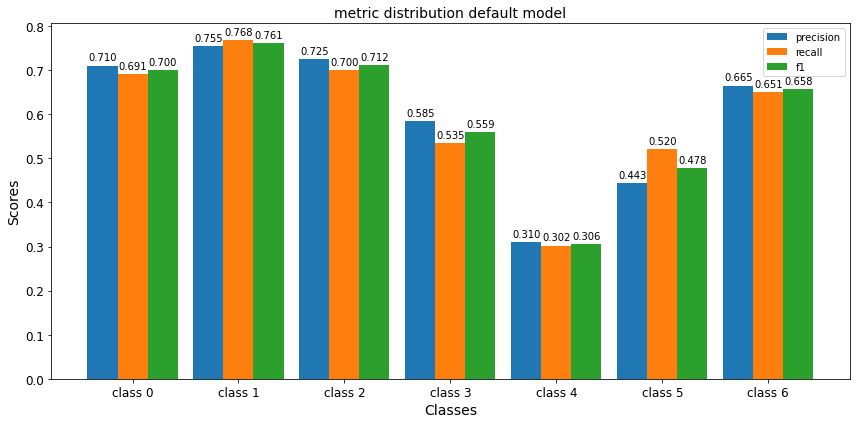

In [42]:
class_weights = {0: 1, 1: 1, 2: 1.1, 3: 2.4, 4: 4, 5: 1.85, 6: 1.5}
metrics_step5 = train_and_display(class_weights)

Great, this improved f1 score for both classes - 3 and 5. 
This is enuogh. You get what we're doing here. Let's compare f1 score distribution for baseline and tuned models.

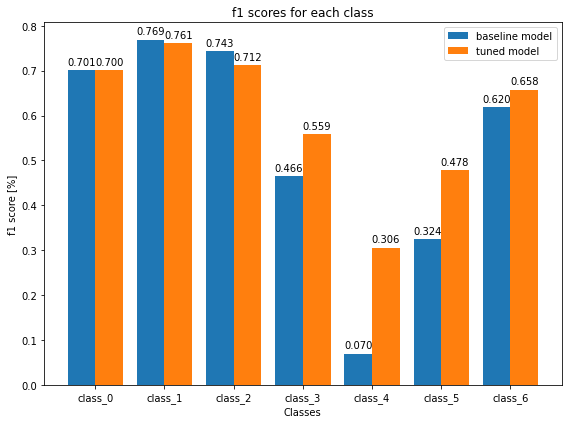

In [43]:
plot_grouped_bar(
    metrics_base['val']['f1'], 
    metrics_step5['val']['f1'], 
    "baseline model", 
    "tuned model",
    xlabel="Classes",
    ylabel="f1 score [%]", 
    title="f1 scores for each class"
)

Notes:
- Our model performs much better for classes with less instances
- We didn't change the weights for classes 0 and 1



### Results for the train set

f1 score macro: 0.5865517141828919
Accuracy score: 0.7140571428571428


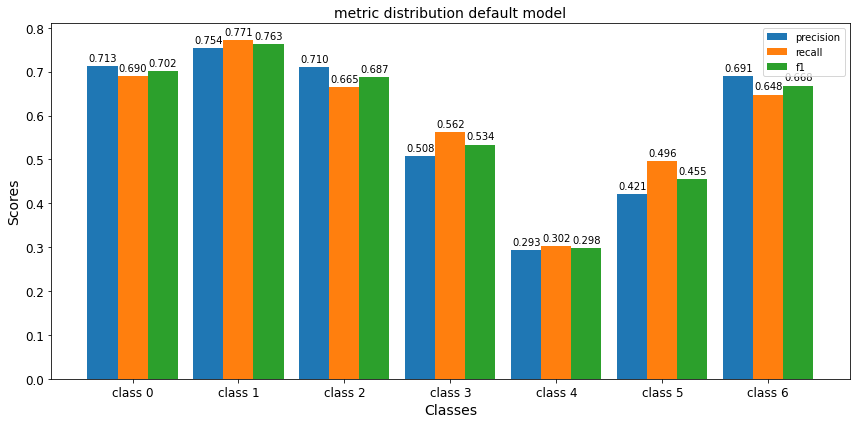

In [44]:
class_weights = {0: 1, 1: 1, 2: 1.1, 3: 2.4, 4: 4, 5: 1.85, 6: 1.5}
metrics_step5_train = train_and_display(class_weights, val=False)

# Conclusions

The purpose of this notebook was to show the challenges of inbalanced data in multiclass classification problems. We tried to improve the f1 score for classes with fewer examples. 

We showed how to implement cost-sensitive learning with scikit-learn by applying class weights to the Logistic Regression model. 

The results can be improved by applying algorithms based on Decision Trees. 